# Project summary 
Project : Customer conversion rate analysis
Data : 
- Coupon Table
    - mem_no : Customer ID 
    - cpn_name : Category for coupon type 
    - cpn_available_amt : coupon amount 
    - test_group 

- Order Table
    - mem_no : Customer ID 
    - ord_no : order id
    - ord_nt : order date 

- Attribute domain
    - Customer : 200 
    - Order : 834 
    - period : '2023-06-05'~'2023-06-18' 

- Hypothesis : 5,000 KRW discount vs 5% discount, which has a higher order conversion rate?
- Test method : A/B test (Double-Difference Method)

In [2]:
# SQL Alchemy load 
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pandas as pd 
from sqlalchemy import text


server="DESKTOP-CK9O8A7\SQLEXPRESS"
database="test"
driver="ODBC Driver 17 for SQL Server"

conn_str=f'mssql+pyodbc://{server}/{database}?driver={driver}'

engine = create_engine(conn_str)

In [3]:
# Raw data load
df_coupon=pd.read_csv('coupon_target_table.csv')
df_order=pd.read_csv('order_master_did.csv')

In [ ]:
# EDA
print(df_coupon) 
print(df_coupon.columns) 
print(df_coupon.dtypes)
# df_order

In [ ]:
# df_coupon.rename(columns={"group":"test_group"},inplace=True)
# df_coupon

In [ ]:
# # data load 
# df_coupon.to_sql('coupon_table',engine,if_exists='append',index=False)
# df_order.to_sql('order_table',engine,if_exists='append',index=False)


In [7]:
# check coupon_table
query = '''
	select *
	from coupon_table ct
'''  
coupon_df = pd.read_sql(query, engine)
coupon_df

,mem_no,cpn_nm,cpn_available_amt,cpn_issued_dt,test_group
0,1,None,NaN,None,CONTROL
1,2,None,NaN,None,CONTROL
2,3,None,NaN,None,CONTROL
3,4,None,NaN,None,CONTROL
4,5,None,NaN,None,CONTROL
...,...,...,...,...,...
295,296,5000krw discount,100000.0,2023-06-12,TEST1_amount
296,297,5000krw discount,100000.0,2023-06-12,TEST1_amount
297,298,5000krw discount,100000.0,2023-06-12,TEST1_amount
298,299,5000krw discount,100000.0,2023-06-12,TEST1_amount


In [ ]:
# domain check
# # coupon_df['cpn_issued_dt'].unique()
# => none, 2023-06-12
# # coupon_df['test_group'].unique()
# => Control, Test1, Test2 

array(['CONTROL', 'TEST1_ratio', 'TEST1_amount'], dtype=object)

In [15]:
# check order_table
query = '''
	select *
	from order_table ot
'''  
order_df = pd.read_sql(query, engine)
order_df

,mem_no,ord_no,ord_dt
0,283,10000,2023-06-18
1,160,10001,2023-06-18
2,10,10002,2023-06-12
3,21,10003,2023-06-11
4,83,10004,2023-06-11
...,...,...,...
829,283,10829,2023-06-06
830,41,10830,2023-06-08
831,49,10831,2023-06-12
832,297,10832,2023-06-13


In [19]:
# domain check
print(len(order_df['mem_no'].unique()))
print(len(order_df['ord_no'].unique()))
print(order_df['ord_dt'].min(),order_df['ord_dt'].max())

200
834
2023-06-05 2023-06-18


In [49]:
# check Double-Difference Method
query = '''
WITH T1 AS (
    SELECT 
        ct.mem_no,
        test_group,
        ord_no,
        CASE 
            WHEN ord_dt BETWEEN '2023-06-05' AND '2023-06-11' THEN 'before'
            WHEN ord_dt BETWEEN '2023-06-12' AND '2023-06-18' THEN 'after' 
        END AS period_status
    FROM coupon_table ct 
    LEFT JOIN order_table ot ON ct.mem_no = ot.mem_no
)

SELECT
    test_group,
    period_status,
    COUNT(distinct(mem_no)) AS mem_cnt
FROM T1
GROUP BY test_group, period_status
having period_status is not null
order by 1,2 desc,3

'''  
df = pd.read_sql(query, engine)
df

,test_group,period_status,mem_cnt
0,CONTROL,before,62
1,CONTROL,after,56
2,TEST1_amount,before,61
3,TEST1_amount,after,62
4,TEST1_ratio,before,36
5,TEST1_ratio,after,40


In [50]:
# bakcup
backup_df=df
df=backup_df
df

,test_group,period_status,mem_cnt
0,CONTROL,before,62
1,CONTROL,after,56
2,TEST1_amount,before,61
3,TEST1_amount,after,62
4,TEST1_ratio,before,36
5,TEST1_ratio,after,40


In [51]:
df['mem_cnt']=df['mem_cnt']/100

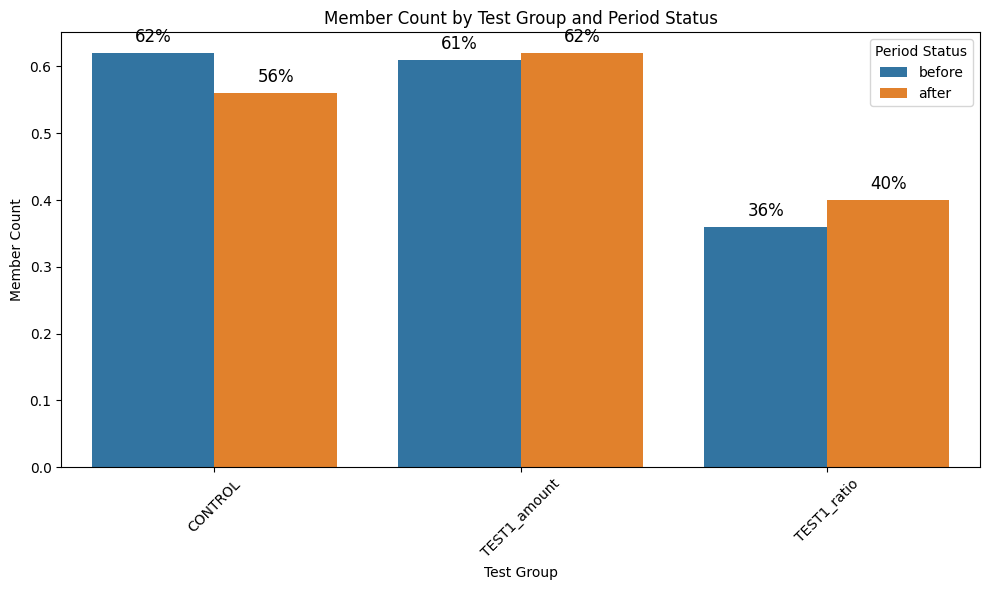

In [52]:
# Data visualizaiton
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='test_group', y='mem_cnt', hue='period_status')
plt.xlabel('Test Group')
plt.xticks(rotation=45)
plt.ylabel('Member Count')
plt.title('Member Count by Test Group and Period Status')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.0%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.legend(title='Period Status')

plt.tight_layout()
plt.show()

In [53]:
# data pivot
df=df.pivot(index='test_group',columns='period_status',values='mem_cnt')
# help(pd.pivot)
df


period_status,after,before
test_group,,
CONTROL,0.56,0.62
TEST1_amount,0.62,0.61
TEST1_ratio,0.40,0.36


In [69]:
# data pivot Double-Difference-Method'
df = df[['before', 'after']]
df['gap']=-df['before']+df['after']
delta=(df.iloc[0,-1])

# 'Double-Difference-Method' 
df['Double-Difference-Method'] = round(df['after'] - df['before'] +0.06,2)
df


C:\Users\KMS\AppData\Local\Temp\ipykernel_9012\1281174222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gap']=-df['before']+df['after']


period_status,before,after,gap,Double-Difference-Method
test_group,,,,
CONTROL,0.62,0.56,-0.06,0.00
TEST1_amount,0.61,0.62,0.01,0.07
TEST1_ratio,0.36,0.40,0.04,0.10


# Conclusion
- Discount coupon has impact on conversion rate(5000krw discount coupon : 7%, 5% discount coupon)